In [1]:
import os #Walk files
import re #REGEX
import numpy as np
import cv2 #Farneback
import matplotlib.pyplot as plt 
import pickle #Dump to files

class ma(object):
    @staticmethod
    def saveMovieMotionHistograms(directory):
        """ Computes the weighted histograms of motion directions between frames 
            for each .mov video in a filetree, saves maps representing one video to files          
            Args: 
                dirctory: Uppermost directory containing subfolders with at least one .mov file
        """
        # traverse directory tree process motion and save result if a .mov file is found
        for root, dirs, files in os.walk(directory):
            for file in files:
                #root+file represents whole path. If it ends with .mov...
                if(re.match(".*\\.mov", root+file)):
                    filepath = root+"\\"+file
                    print('Processing: ' + filepath)
                    mapOfCurrentVideo = ma.processMotionInClip(cv2.VideoCapture(filepath))
                    #Create 
                    #os.makedirs(os.path.dirname(writeFilepath), exist_ok=True)
                    with open(root +"\\"+file + ".motHistMap", 'wb') as handle:
                        pickle.dump(mapOfCurrentVideo, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

    
    @staticmethod
    def loadMotionHistogramsToHeightMaps(directory):
        """ Loads the previosly saved weighted histograms of motion directions between frames 
            for each .mov video from any nested folder structure        
            Args: 
                directory: Uppermost directory containing subfolders with at least one .mov file
            Returns: Nested dictionary (map) where the uppermost layer represents the foldernames containing
                the videos i.e. stimulus categories. The latter are the keys on the next level. The corresponding
                values are the dictionaries mapping framenumbers to weighted motion histograms
        """
        motionHistMaps = {}
        fileIdentifierToData = {}
        
        for root, dirs, files in os.walk(directory):
            fileIdentifierToData = {}
            foldername = root.split("\\")[-1] #isolate last part of path
            for file in files:
                if(re.match(".*\\.motHistMap", root+file)):
                    filepath = root+"\\"+file
                    fileIdentifier = file.split(".")[0] #isolate filename-part before .
                    #print('Folder: ' + foldername )
                    #print('Fileidentifier: ' + fileIdentifier)

                    with open(filepath, 'rb') as handle:
                        heightMap = ma.heightMapOfVideosMotionHistograms(pickle.load(handle))
                        #print(type(heightMap[0][0]))
                    fileIdentifierToData[fileIdentifier] = heightMap
                    #Apperently this notation doesn't work in a loop:
                    #motionHistMaps[foldername] = {fileIdentifier:heightMap}
                    
                    motionHistMaps[foldername] = fileIdentifierToData
        return motionHistMaps                           
                    
    
    @staticmethod
    def plotHistogram360(values, title):
        """ Plots histogram with 36 bins to the jupyter notebook
            Args:
                values: 1D array containing 36 values
                title: Title of the histogram
        """
        bins = (np.arange(36)*10)-170 #start at -170. Go up in steps of 10 to 180
        values = np.abs(values)#Discard minus
        y_pos = np.arange(len(values)) -17
        plt.bar(y_pos, values)
        plt.xticks([-18,-9, 0, 9, 18],['-180°',"-90°","0°","90°", "180°"])
        plt.ylabel('Amount of motion')
        plt.title(title)
        plt.show()
        
    @staticmethod
    def plotHeightMap(heightMap):
        from pylab import pcolor, show, yticks, xticks, colorbar
        pcolor(heightMap, cmap = 'plasma')
        yticks([0,8,17,26,35],[-180,-90,0,90,180,-90,0,90,180])
        colorbar()
        show()
        
    @staticmethod
    def weightedHistogram(pvrs, flow):
        """ Computes a histogram of the motion directions detected by farneback algorithm,
            weights each bin by the strength of motion in the respective direction
        
            Args:
                pvrs: any frame of the video or any other 2d numpy array with the same size
                flow: the return of the Farneback algorithm
            Returns:
                A weighted histogram of motion directions between two frames
        """
        bins = (np.arange(36)*10)-170 #start at -170. Go up in steps of 10 to 180

        
        (dispStrength, dispDir) = ma.computeFrameMeasures(pvrs,flow)
        weightedHist, bin_edges = np.histogram(dispDir.flatten(), weights = dispStrength.flatten(), bins = bins)
        return weightedHist
    
    @staticmethod
    def computeFrameMeasures(pvrs, flow):
        """    Compute the displacement strength (length of displacement vector) and direction 
            Args:
                pvrs: any frame of the video or any other 2d numpy array with the same size
                flow: the return of the Farneback algorithm
            Returns:
                dispStrength: A 2D array representing the strength of the displacement for each 
                pixel detected between two frames

                dispDir: A 2D array representing the direction of the displacement
        """
        dispStrength = np.empty(np.shape(pvrs))
        dispDir = np.empty(np.shape(pvrs))
        dispStrength.fill(-np.finfo('d').max)#Assign - Infinity
        dispDir.fill(-np.finfo('d').max)#Assign - Infinity
        for y in range(0, np.shape(flow)[0]): # For each pixel
            for x in range(0, np.shape(flow)[1]):
                dispStrength[y][x] = np.linalg.norm(flow[y][x]) #equivalent to sqrt(a^2+b^2)
                dispDir[y][x] = np.degrees(np.arctan2(flow[y][x][0],flow[y][x][1])) #returns direction of vector
        return(dispStrength, dispDir)
    
    @staticmethod
    def heightMapOfVideosMotionHistograms(myMap):
        """Computes a height-map represenatation of the weighted motion direction histograms for
            a single video clip
            Args:
                myMap: A map containg pairs of frame number to weighted motion direction histograms
                        for all frames of a video
            Returns:
                arrayHeightMap: 2D array representing one height map per column
        """
        arrayHeightMap = []
        for dir in range(0, len(myMap[0])):#loop through directions (will be Y)
            motionAcrossVideos = []
            for frame in range(0, len(myMap)): #loop through frames (will be X)
                motionAcrossVideos.append(myMap[frame][dir])
            arrayHeightMap.append(np.array(motionAcrossVideos))
        return arrayHeightMap
    
    @staticmethod
    def processMotionInClip(cap):
        """Loops through all frames of a movie clip and computes a weighted histogram
            of motion directions for each pair of subsequent frames
            Args:
                cap: Capture of movie file as returned by cv.VideoCapture("C:/1.mov")
            Returns: Map of integer frame-IDs to weighted histograms of motion directions
        """

        ret, frame1 = cap.read()
        prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

        frameHistMap = {}

        currentFrame = 0
        while (True): #Continue looping until break
            ret, frame2 = cap.read()
            #if currentFrame == 20: #DEBUGGING
            #    break

            if ret == False: #There is no frame anymore
                print("Reached end of video")
                break
            else:
                print("Loading frame")

                next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
                flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 2, 5, 1.2, 0)
                frameHistMap[currentFrame] = ma.weightedHistogram(prvs, flow)
                prvs = next
                currentFrame += 1
        return frameHistMap
    
    @staticmethod
    def averageAmountOfMotionToCSV(heightMaps):
        outputFile = "Category;Stimulus;Average amount of motion\n"
        for category, v in heightMaps.items():
            if isinstance(v, dict):
                for stimulus, heightMap in v.items():
                    outputFile = outputFile + category + ";" + stimulus + ";" + str(np.mean(heightMap)) + "\n"
            else:
                  raise ValueError('Toplevel dictionary should only contain dictionaries')
        with open("AverageMotion.csv", "w") as text_file:
            print(outputFile, file=text_file)

This is the motion analysis utility class (ma) that aims at processing motion within and across video stimuli. 
Author: Michael Gerstenberger 2017

Testing the computation and strorage of Motion Histograms (Will take up to several hours depending on the machine in use and the number of videos to be processed)

In [2]:
#Commented out for security reasons (Takes 3 hours)
#ma.saveMovieMotionHistograms('C:\\Users\\Eler\\Documents\\Python Scripts\\Motion Analysis')

Loading the precomputed maps again

In [3]:
heightMaps = ma.loadMotionHistogramsToHeightMaps('C:\\Users\\Eler\\Documents\\Python Scripts\\Motion Analysis')

Test of iterating through the 2 level nested dictionary containing the motion histogram height maps.
Test of displaying the motion histogram height maps.

- Category    : 02_Sol1_Arg
--- Stimulus  : Sol_Arg8_P3_MR


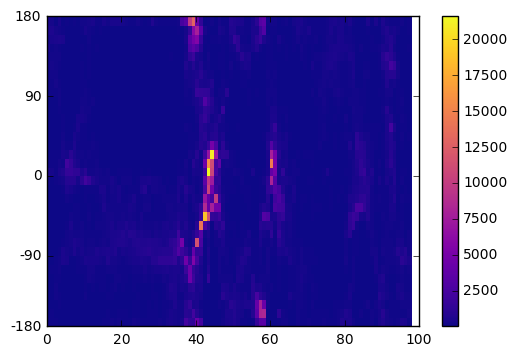

Average amount of motion (No. of pixels moving * strength of displacement): 359.4100591177988


----------------------------------------------------------
- Category    : 02_Sol1_Arg
--- Stimulus  : Sol_Arg3_P1_FL


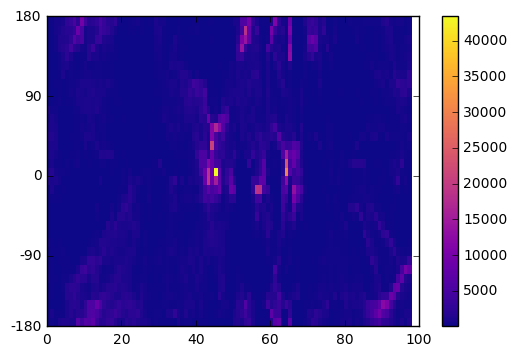

Average amount of motion (No. of pixels moving * strength of displacement): 890.4922622711607


----------------------------------------------------------
- Category    : 02_Sol1_Arg
--- Stimulus  : Sol_Arg3_P1_MR


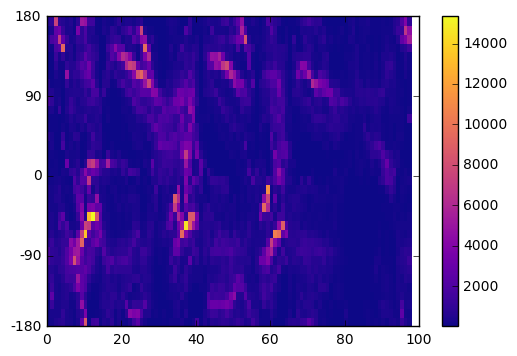

Average amount of motion (No. of pixels moving * strength of displacement): 784.1678547239344


----------------------------------------------------------
- Category    : 02_Sol1_Arg
--- Stimulus  : Sol_Arg2_P2_MR


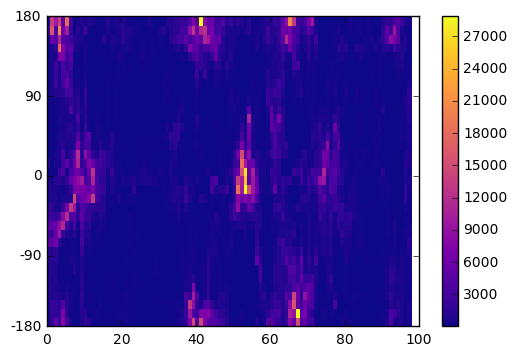

Average amount of motion (No. of pixels moving * strength of displacement): 1046.8471876543686


----------------------------------------------------------
- Category    : 02_Sol1_Arg
--- Stimulus  : Sol_Arg1_P2_FL


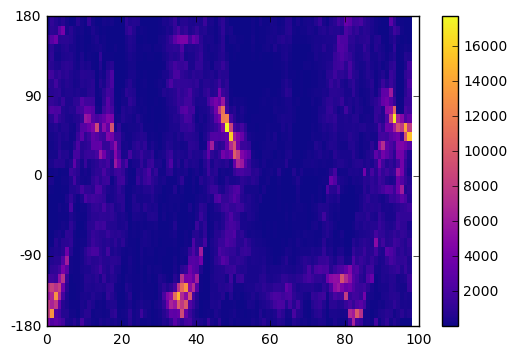

Average amount of motion (No. of pixels moving * strength of displacement): 849.597328384784


----------------------------------------------------------
- Category    : 02_Sol1_Arg
--- Stimulus  : Sol_Arg8_P3_FL


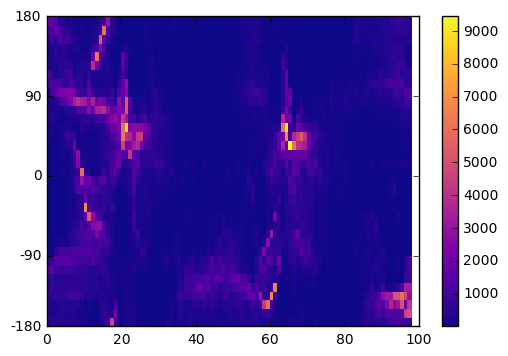

Average amount of motion (No. of pixels moving * strength of displacement): 393.2831578393729


----------------------------------------------------------
- Category    : 02_Sol1_Arg
--- Stimulus  : Sol_Arg2_P2_FL


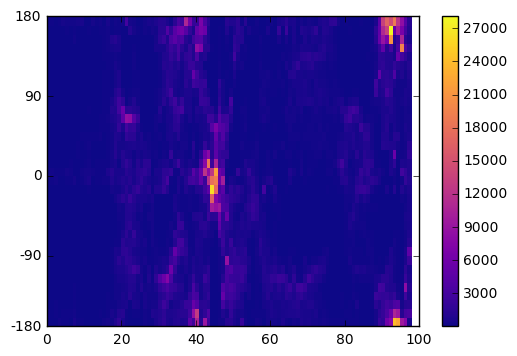

Average amount of motion (No. of pixels moving * strength of displacement): 740.9675573223778


----------------------------------------------------------
- Category    : 02_Sol1_Arg
--- Stimulus  : Sol_Arg1_P2_MR


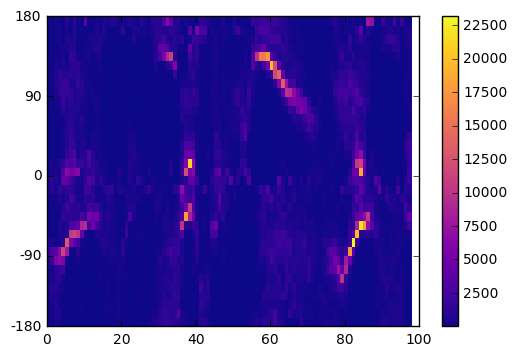

Average amount of motion (No. of pixels moving * strength of displacement): 736.5462450947881


----------------------------------------------------------
- Category    : 09_Sol2_Lau
--- Stimulus  : Sol_Lau5_P3_FR


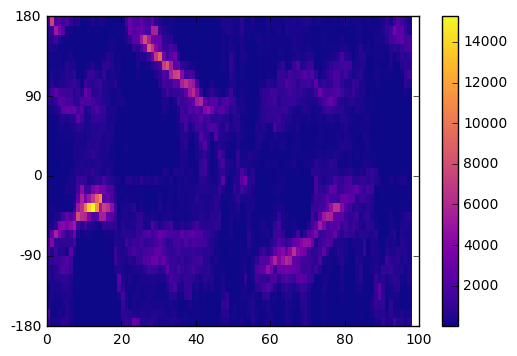

Average amount of motion (No. of pixels moving * strength of displacement): 637.6508381501931


----------------------------------------------------------
- Category    : 09_Sol2_Lau
--- Stimulus  : Sol_Lau5_P3_ML


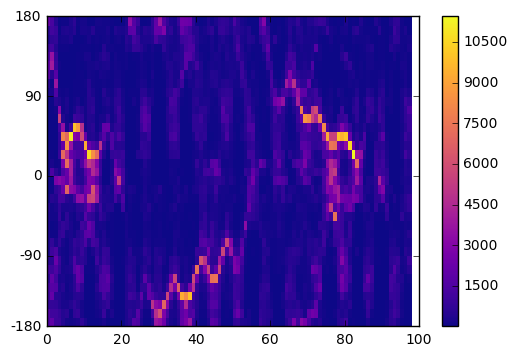

Average amount of motion (No. of pixels moving * strength of displacement): 629.1097053074914


----------------------------------------------------------
- Category    : 09_Sol2_Lau
--- Stimulus  : Sol_Lau1_P1_FR


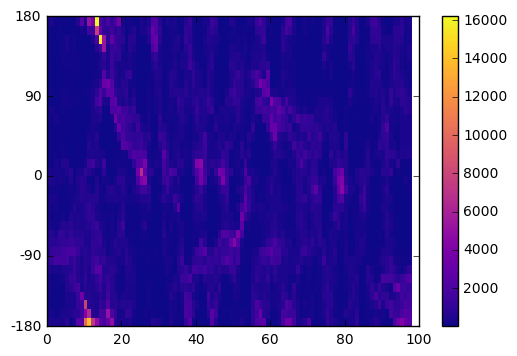

Average amount of motion (No. of pixels moving * strength of displacement): 517.6752691354967


----------------------------------------------------------
- Category    : 09_Sol2_Lau
--- Stimulus  : Sol_Lau2_P2_FR


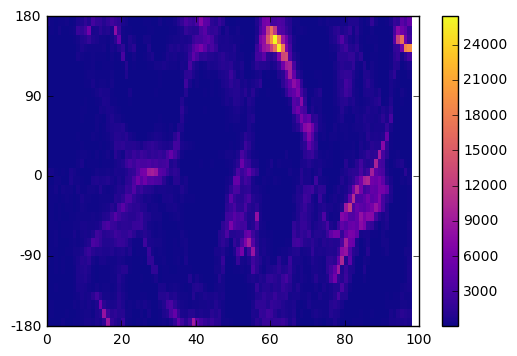

Average amount of motion (No. of pixels moving * strength of displacement): 866.8885684759704


----------------------------------------------------------
- Category    : 09_Sol2_Lau
--- Stimulus  : Sol_Lau1_P1_ML


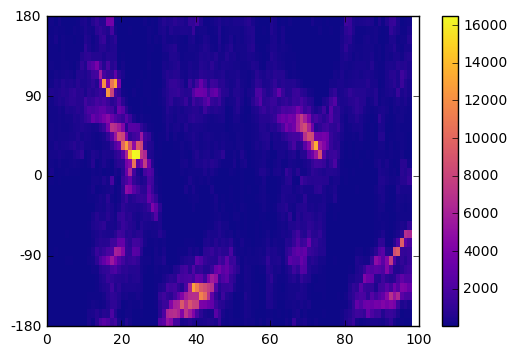

Average amount of motion (No. of pixels moving * strength of displacement): 684.1602961134795


----------------------------------------------------------
- Category    : 09_Sol2_Lau
--- Stimulus  : Sol_Lau4_P3_ML


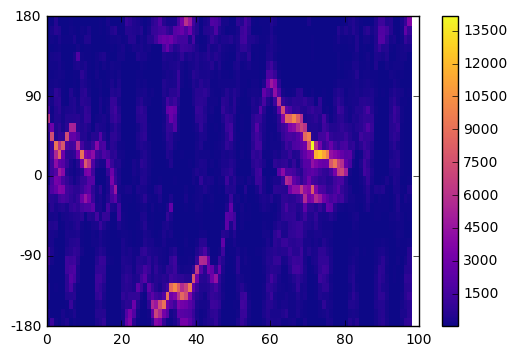

Average amount of motion (No. of pixels moving * strength of displacement): 584.1765045714711


----------------------------------------------------------
- Category    : 09_Sol2_Lau
--- Stimulus  : Sol_Lau2_P2_ML


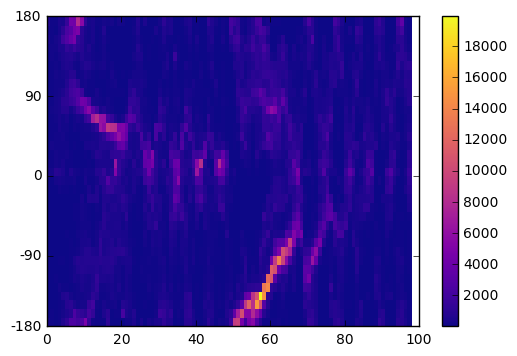

Average amount of motion (No. of pixels moving * strength of displacement): 655.0431165530879


----------------------------------------------------------
- Category    : 09_Sol2_Lau
--- Stimulus  : Sol_Lau4_P3_FR


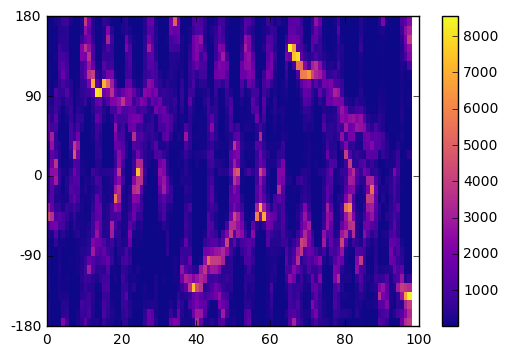

Average amount of motion (No. of pixels moving * strength of displacement): 680.1898525407511


----------------------------------------------------------
- Category    : 05_Sol1_Cel
--- Stimulus  : Sol_Cel7_P1_FL


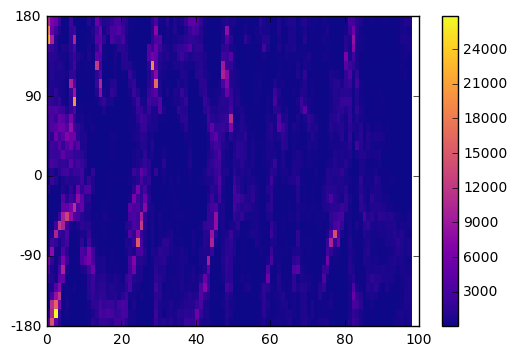

Average amount of motion (No. of pixels moving * strength of displacement): 863.7886183180476


----------------------------------------------------------
- Category    : 05_Sol1_Cel
--- Stimulus  : Sol_Cel1_P3_MR


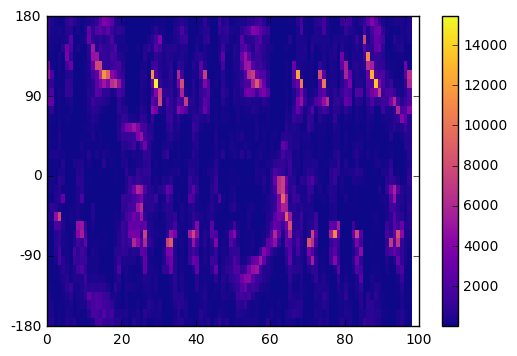

Average amount of motion (No. of pixels moving * strength of displacement): 743.0317405012165


----------------------------------------------------------
- Category    : 05_Sol1_Cel
--- Stimulus  : Sol_Cel4_P2_FL


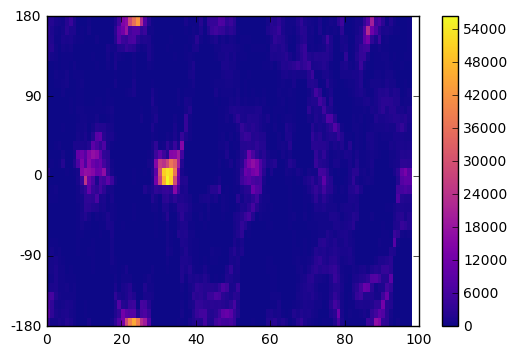

Average amount of motion (No. of pixels moving * strength of displacement): 1387.7885514812206


----------------------------------------------------------
- Category    : 05_Sol1_Cel
--- Stimulus  : Sol_Cel3_P3_FL


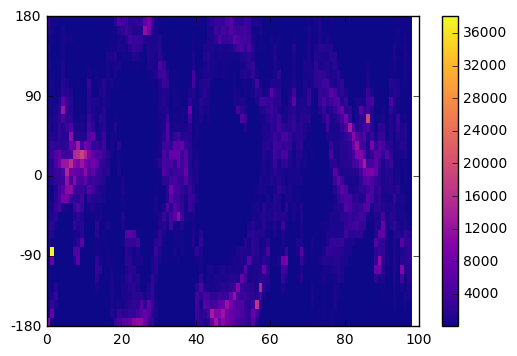

Average amount of motion (No. of pixels moving * strength of displacement): 1171.7568589004059


----------------------------------------------------------
- Category    : 05_Sol1_Cel
--- Stimulus  : Sol_Cel3_P3_MR


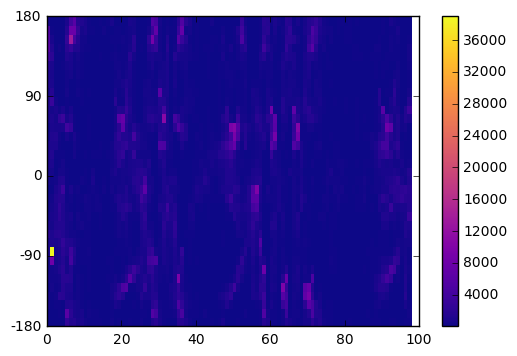

Average amount of motion (No. of pixels moving * strength of displacement): 626.6260430770275


----------------------------------------------------------
- Category    : 05_Sol1_Cel
--- Stimulus  : Sol_Cel7_P1_MR


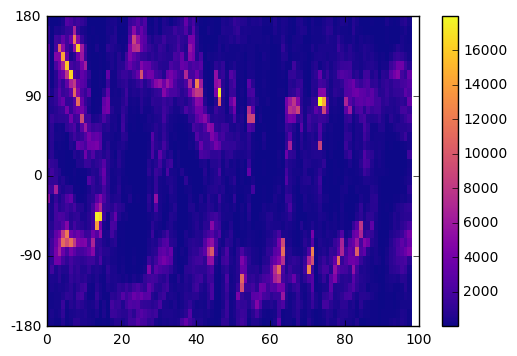

Average amount of motion (No. of pixels moving * strength of displacement): 1042.4957578285237


----------------------------------------------------------
- Category    : 05_Sol1_Cel
--- Stimulus  : Sol_Cel4_P2_MR


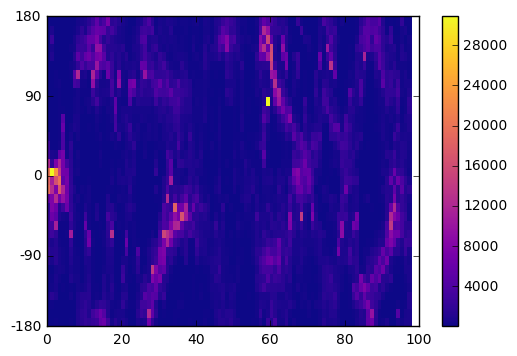

Average amount of motion (No. of pixels moving * strength of displacement): 1313.7553343122122


----------------------------------------------------------
- Category    : 05_Sol1_Cel
--- Stimulus  : Sol_Cel1_P3_FL


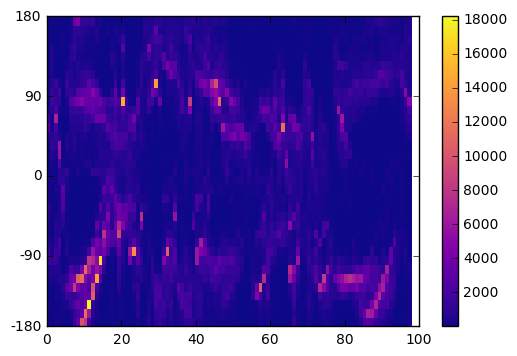

Average amount of motion (No. of pixels moving * strength of displacement): 826.0500782354078


----------------------------------------------------------
- Category    : 06_Sol2_Cel
--- Stimulus  : Sol_Cel3_P1_FR


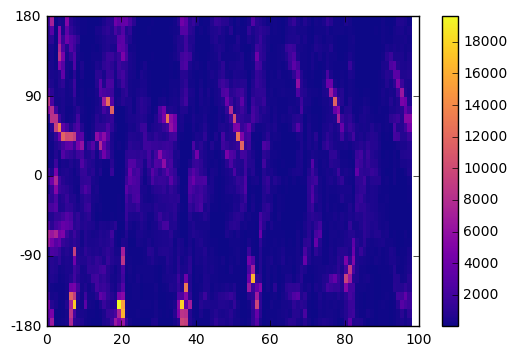

Average amount of motion (No. of pixels moving * strength of displacement): 808.0325367467424


----------------------------------------------------------
- Category    : 06_Sol2_Cel
--- Stimulus  : Sol_Cel4_P2_ML


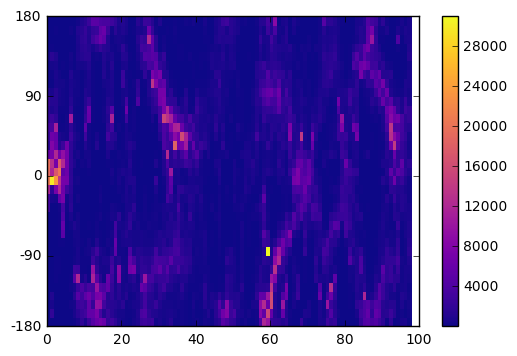

Average amount of motion (No. of pixels moving * strength of displacement): 1309.2761881595547


----------------------------------------------------------
- Category    : 06_Sol2_Cel
--- Stimulus  : Sol_Cel3_P1_ML


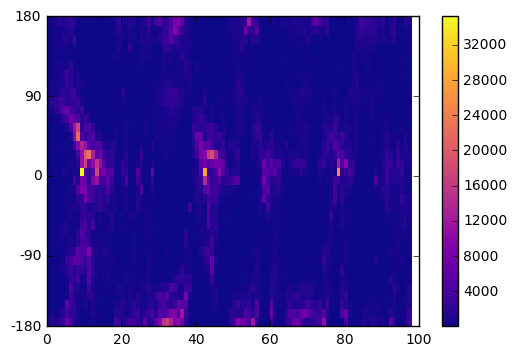

Average amount of motion (No. of pixels moving * strength of displacement): 945.2580619836905


----------------------------------------------------------
- Category    : 06_Sol2_Cel
--- Stimulus  : Sol_Cel4_P2_FR


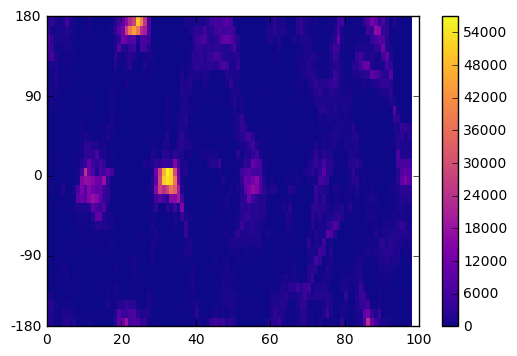

Average amount of motion (No. of pixels moving * strength of displacement): 1399.6706923335582


----------------------------------------------------------
- Category    : 06_Sol2_Cel
--- Stimulus  : Sol_Cel7_P2_FR


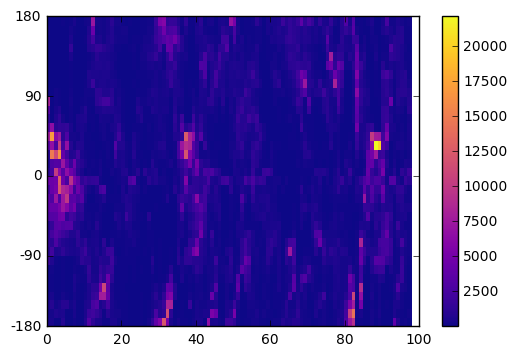

Average amount of motion (No. of pixels moving * strength of displacement): 805.554285905143


----------------------------------------------------------
- Category    : 06_Sol2_Cel
--- Stimulus  : Sol_Cel1_P3_FR


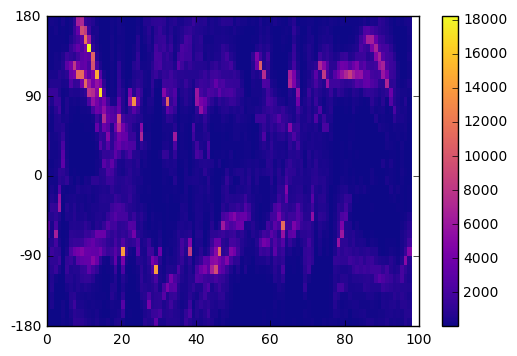

Average amount of motion (No. of pixels moving * strength of displacement): 828.3829985390221


----------------------------------------------------------
- Category    : 06_Sol2_Cel
--- Stimulus  : Sol_Cel1_P3_ML


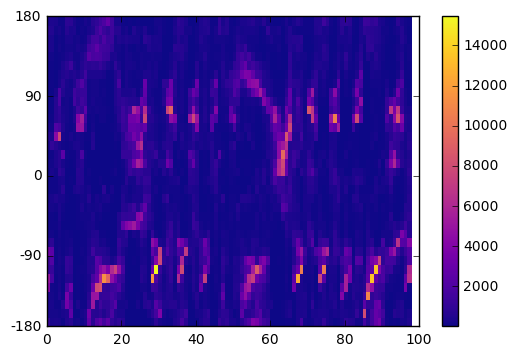

Average amount of motion (No. of pixels moving * strength of displacement): 736.9645800033915


----------------------------------------------------------
- Category    : 06_Sol2_Cel
--- Stimulus  : Sol_Cel7_P2_ML


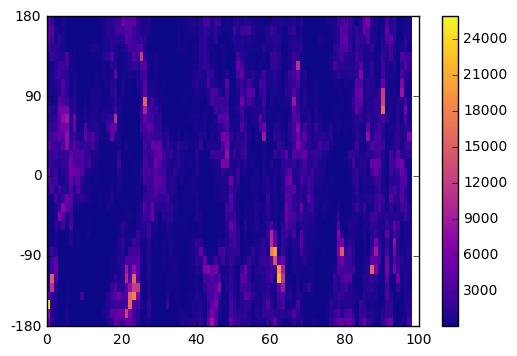

Average amount of motion (No. of pixels moving * strength of displacement): 1179.41215627696


----------------------------------------------------------
- Category    : 03_Sol2_Arg
--- Stimulus  : Sol_Arg8_P1_FR


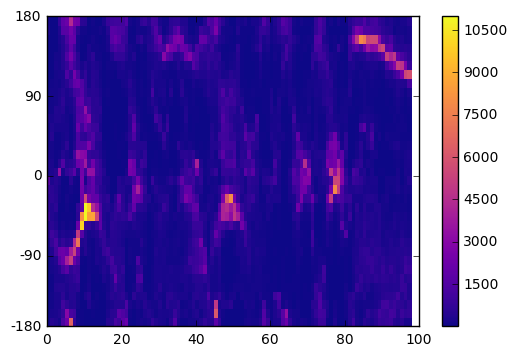

Average amount of motion (No. of pixels moving * strength of displacement): 512.9931761236967


----------------------------------------------------------
- Category    : 03_Sol2_Arg
--- Stimulus  : Sol_Arg2_P3_ML


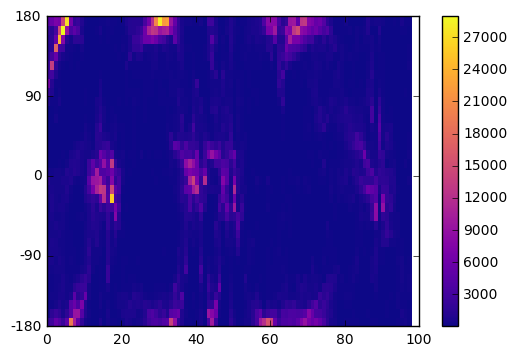

Average amount of motion (No. of pixels moving * strength of displacement): 883.6248059456973


----------------------------------------------------------
- Category    : 03_Sol2_Arg
--- Stimulus  : Sol_Arg1_P2_FR


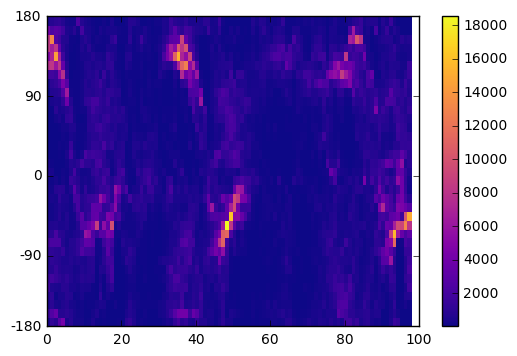

Average amount of motion (No. of pixels moving * strength of displacement): 846.4386125069171


----------------------------------------------------------
- Category    : 03_Sol2_Arg
--- Stimulus  : Sol_Arg3_P1_ML


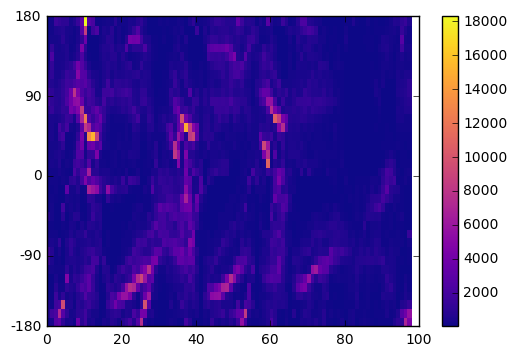

Average amount of motion (No. of pixels moving * strength of displacement): 786.6501889754851


----------------------------------------------------------
- Category    : 03_Sol2_Arg
--- Stimulus  : Sol_Arg8_P1_ML


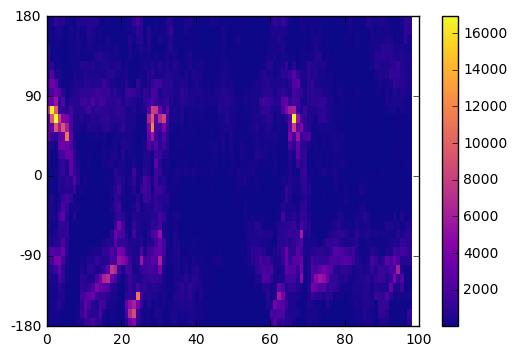

Average amount of motion (No. of pixels moving * strength of displacement): 559.6267895999621


----------------------------------------------------------
- Category    : 03_Sol2_Arg
--- Stimulus  : Sol_Arg3_P1_FR


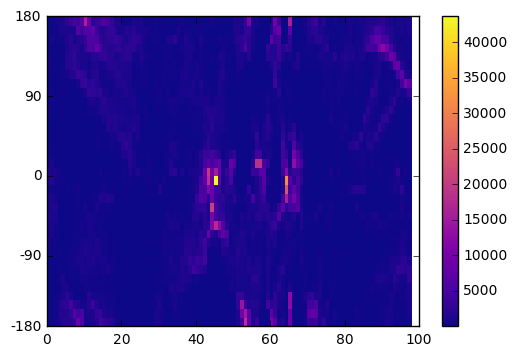

Average amount of motion (No. of pixels moving * strength of displacement): 901.514875701368


----------------------------------------------------------
- Category    : 03_Sol2_Arg
--- Stimulus  : Sol_Arg2_P3_FR


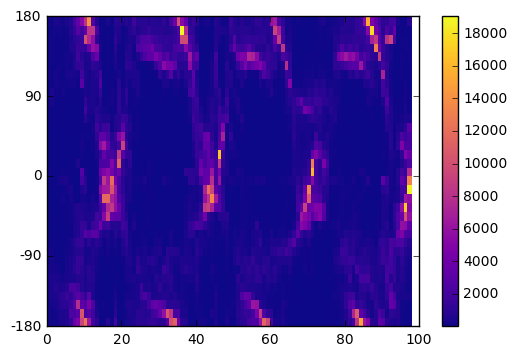

Average amount of motion (No. of pixels moving * strength of displacement): 903.5057531365057


----------------------------------------------------------
- Category    : 03_Sol2_Arg
--- Stimulus  : Sol_Arg1_P2_ML


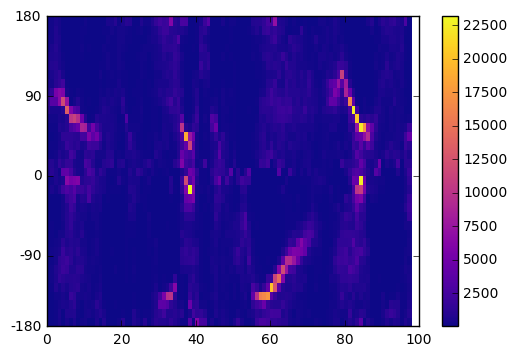

Average amount of motion (No. of pixels moving * strength of displacement): 731.9012978015566


----------------------------------------------------------
- Category    : 08_Sol1_Lau
--- Stimulus  : Sol_Lau5_P2_MR


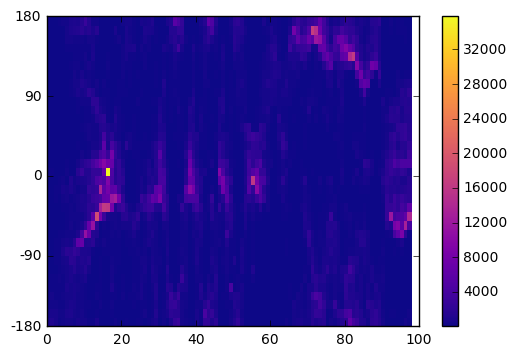

Average amount of motion (No. of pixels moving * strength of displacement): 795.451518908118


----------------------------------------------------------
- Category    : 08_Sol1_Lau
--- Stimulus  : Sol_Lau4_P3_FL


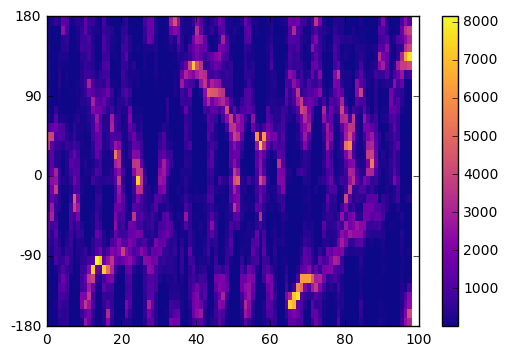

Average amount of motion (No. of pixels moving * strength of displacement): 681.9295684162411


----------------------------------------------------------
- Category    : 08_Sol1_Lau
--- Stimulus  : Sol_Lau1_P1_FL


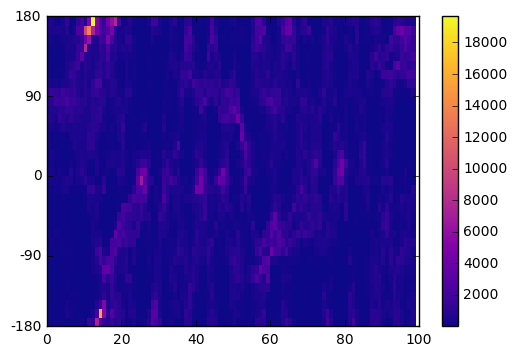

Average amount of motion (No. of pixels moving * strength of displacement): 524.8710119898074


----------------------------------------------------------
- Category    : 08_Sol1_Lau
--- Stimulus  : Sol_Lau4_P3_MR


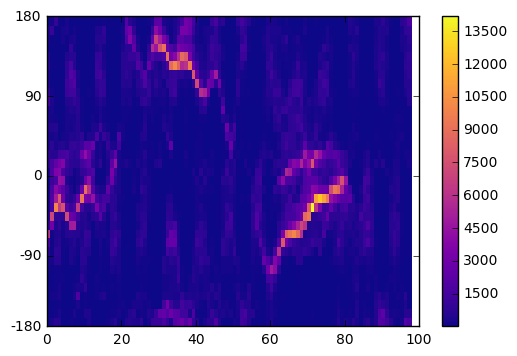

Average amount of motion (No. of pixels moving * strength of displacement): 578.9885647142984


----------------------------------------------------------
- Category    : 08_Sol1_Lau
--- Stimulus  : Sol_Lau2_P1_MR


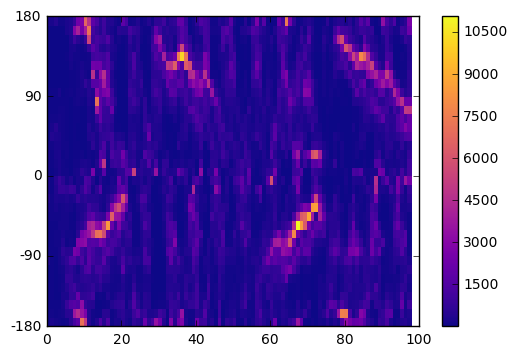

Average amount of motion (No. of pixels moving * strength of displacement): 714.3088533447585


----------------------------------------------------------
- Category    : 08_Sol1_Lau
--- Stimulus  : Sol_Lau5_P2_FL


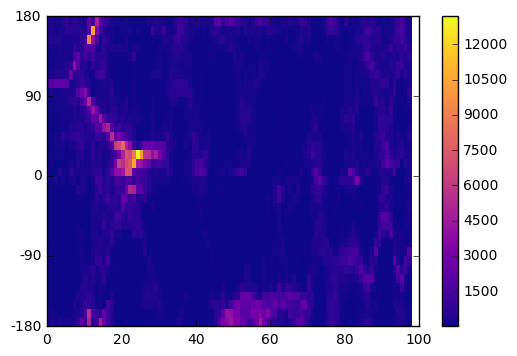

Average amount of motion (No. of pixels moving * strength of displacement): 403.4589919367399


----------------------------------------------------------
- Category    : 08_Sol1_Lau
--- Stimulus  : Sol_Lau1_P1_MR


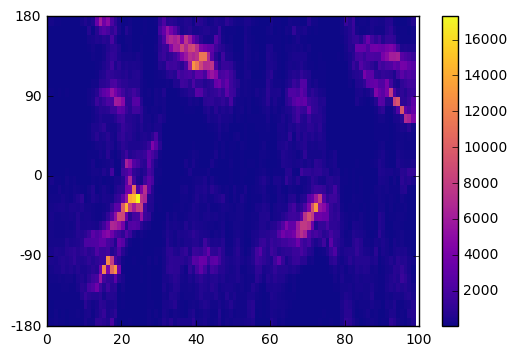

Average amount of motion (No. of pixels moving * strength of displacement): 688.0771168634188


----------------------------------------------------------
- Category    : 08_Sol1_Lau
--- Stimulus  : Sol_Lau2_P1_FL


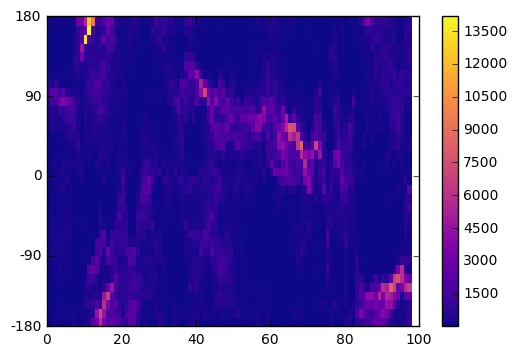

Average amount of motion (No. of pixels moving * strength of displacement): 543.592714493136


----------------------------------------------------------


In [4]:
for category, v in heightMaps.items():
    if isinstance(v, dict):
        for stimulus, heightMap in v.items():
            print("- Category    : " + str(category))
            print("--- Stimulus  : " + str(stimulus))
            #Commented out for time reasons
            ma.plotHeightMap(heightMap)
            print("Average amount of motion" +
                  " (No. of pixels moving * strength of displacement): " + str(np.mean(heightMap)))
            print("\n\n----------------------------------------------------------")
    else:
      raise ValueError('Toplevel dictionary should only contain dictionaries')

In [6]:
ma.averageAmountOfMotionToCSV(ma.loadMotionHistogramsToHeightMaps('C:\\Users\\Eler\\Documents\\Python Scripts\\Motion Analysis'))

Crosscorrelation manually

0.11198958002037417


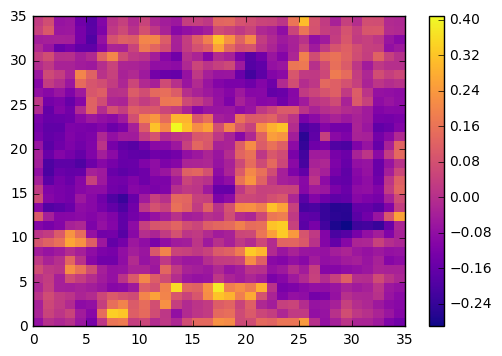

In [7]:
a = heightMaps['09_Sol2_Lau']['Sol_Lau4_P3_FR']
b = heightMaps['05_Sol1_Cel']['Sol_Cel3_P3_FL']

#a = np.asarray(a)[:,:80]
#b = np.asarray(b)[:,:80]
#ma.plotHeightMap(a)
#ma.plotHeightMap(b)

motionAcrossVideosForAllVideos = np.corrcoef(a,b)[35:,:35]
print(np.std(motionAcrossVideosForAllVideos))

# plotting the correlation matrix
from pylab import pcolor, show, yticks, xticks, colorbar
pcolor(motionAcrossVideosForAllVideos, cmap = 'plasma')
#yticks([0,8,17,26,35,44,53,62,70],[-180,-90,0,90,180,-90,0,90,180])

colorbar()
show()

Crosscorrelation for all pairs of clips

In [8]:
#Let's define an output list
standardDevCrossCorr = [[""]]

#Now lets run through our dictionary and save the Stimulus Names

for category in list(heightMaps.keys()):
    for stimulus, heightMap in heightMaps[category].items(): #    for heightMap in list(heightMaps[category].values()):
        #standardDevCrossCorr.append([stimulus])
        #standardDevCrossCorr[0].append(stimulus)
        standardDevCrossCorr.append([category])
        standardDevCrossCorr[0].append(category)

#Here we want to store pairs of "Category X Category" to [sumOfCorrOfStimuliOfCategory, nStimuliInCategory] lists:
catPermut = {} 
for category in list(heightMaps.keys()):
    for stimulus, heightMap in heightMaps[category].items():
        for category1 in list(heightMaps.keys()):
            for stimulus1 ,heightMap1 in heightMaps[category1].items():
                #print(category + " x " + category1)
                catPermut[category + " x " + category1]=[0,0,category,category1] #INITIALIZE

line = 1
for category in list(heightMaps.keys()):
    for stimulus, heightMap in heightMaps[category].items(): #    for heightMap in list(heightMaps[category].values()):
        for category1 in list(heightMaps.keys()):
            for stimulus1 ,heightMap1 in heightMaps[category1].items():
                
                #1.Make sure both heightMaps have the same shape: 
                #(Discard if there are additional frmes in one video)
                if(len(heightMap1[0])!=len(heightMap[0])):
                    frames = min(len(heightMap1[0]),len(heightMap[0]))
                    heightMap = np.asarray(heightMap)[:,:frames]
                    heightMap1 = np.asarray(heightMap1)[:,:frames]
                
                #2.Compute Standard deviation of motion cross correlation
                crossCor = np.corrcoef(heightMap,heightMap1)[35:,:35]
                std = np.std(crossCor)
                standardDevCrossCorr[line].append(std)
                
                #3.Add up the respective values in catPermut
                catPermut[category + " x " + category1][0] += std
                catPermut[category + " x " + category1][1] += 1
        #We computed a new line of stimuli crosscorrelations
        line += 1     

#Compute average across categories:  
for concat, v in catPermut.items(): #items() yields touples (key,value) 
    if(v[2]!=v[3]):#Different categories
        print(concat + "\t" + str(v[0]/v[1]))
print("")
for concat, v in catPermut.items():
    if(v[2]==v[3]):#Same categories
        print(concat + "\t" + str(v[0]/v[1]))

02_Sol1_Arg x 08_Sol1_Lau	0.14885245209036663
05_Sol1_Cel x 02_Sol1_Arg	0.13291815869643242
02_Sol1_Arg x 05_Sol1_Cel	0.13291815869643245
03_Sol2_Arg x 02_Sol1_Arg	0.1532020543182124
06_Sol2_Cel x 03_Sol2_Arg	0.13401962562896277
09_Sol2_Lau x 06_Sol2_Cel	0.137732286620037
09_Sol2_Lau x 05_Sol1_Cel	0.13597009415758973
05_Sol1_Cel x 06_Sol2_Cel	0.14502514517987716
06_Sol2_Cel x 05_Sol1_Cel	0.14502514517987716
05_Sol1_Cel x 03_Sol2_Arg	0.13447972452327692
08_Sol1_Lau x 02_Sol1_Arg	0.14885245209036654
06_Sol2_Cel x 08_Sol1_Lau	0.13676204682676132
03_Sol2_Arg x 06_Sol2_Cel	0.1340196256289628
08_Sol1_Lau x 03_Sol2_Arg	0.14938635225981925
02_Sol1_Arg x 06_Sol2_Cel	0.1323877435553018
09_Sol2_Lau x 03_Sol2_Arg	0.14647921007489678
05_Sol1_Cel x 09_Sol2_Lau	0.13597009415758976
08_Sol1_Lau x 06_Sol2_Cel	0.13676204682676135
03_Sol2_Arg x 08_Sol1_Lau	0.14938635225981925
03_Sol2_Arg x 05_Sol1_Cel	0.1344797245232769
09_Sol2_Lau x 08_Sol1_Lau	0.16490787976652416
06_Sol2_Cel x 09_Sol2_Lau	0.137732286620

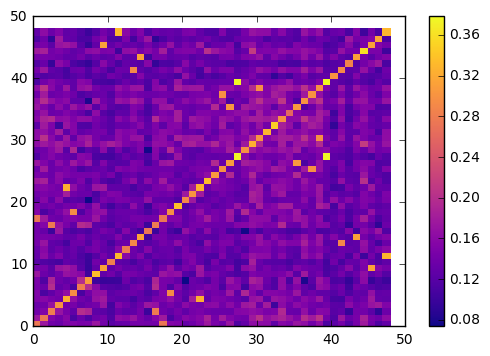

In [9]:
standardDevCrossCorr=standardDevCrossCorr[1:]
standardDevCrossCorr=[standardDevCrossCorr[x][1:] for x in range(len(standardDevCrossCorr))]

standardDevCrossCorr = np.asarray(standardDevCrossCorr)
standardDevCrossCorr = standardDevCrossCorr.astype(np.float)
from pylab import pcolor, show, yticks, xticks, colorbar
pcolor(standardDevCrossCorr, cmap = 'plasma')
colorbar()
show()

In [176]:
from IPython.display import HTML, display
import tabulate
#table = [["a",1],["b",2]]
table = standardDevCrossCorr
display(HTML(tabulate.tabulate(table, tablefmt='html')))

,05_Sol1_Cel,05_Sol1_Cel,05_Sol1_Cel,05_Sol1_Cel,05_Sol1_Cel,05_Sol1_Cel,05_Sol1_Cel,05_Sol1_Cel,09_Sol2_Lau,09_Sol2_Lau,09_Sol2_Lau,09_Sol2_Lau,09_Sol2_Lau,09_Sol2_Lau,09_Sol2_Lau,09_Sol2_Lau,08_Sol1_Lau,08_Sol1_Lau,08_Sol1_Lau,08_Sol1_Lau,08_Sol1_Lau,08_Sol1_Lau,08_Sol1_Lau,08_Sol1_Lau,02_Sol1_Arg,02_Sol1_Arg,02_Sol1_Arg,02_Sol1_Arg,02_Sol1_Arg,02_Sol1_Arg,02_Sol1_Arg,02_Sol1_Arg,03_Sol2_Arg,03_Sol2_Arg,03_Sol2_Arg,03_Sol2_Arg,03_Sol2_Arg,03_Sol2_Arg,03_Sol2_Arg,03_Sol2_Arg,06_Sol2_Cel,06_Sol2_Cel,06_Sol2_Cel,06_Sol2_Cel,06_Sol2_Cel,06_Sol2_Cel,06_Sol2_Cel,06_Sol2_Cel
05_Sol1_Cel,0.2723871473849002,0.12893530936218756,0.11541341802490812,0.1024118052135706,0.15489752410522836,0.1441243864139593,0.11864340011082844,0.1345062974627303,0.07673473587715059,0.1135286228177063,0.1267526609983288,0.13166220421969085,0.13081538851664123,0.10999337165099596,0.13730631378031588,0.10723552939574016,0.13533146334039126,0.12587173856118739,0.11353618114796207,0.10833955022054709,0.10991451090008547,0.11223323465205258,0.12159834798053437,0.12350975332220474,0.11804421479681212,0.14043883883197944,0.1744367343826494,0.11108234897548597,0.11126708634625548,0.1000201348971303,0.13120739008000804,0.1207853203709655,0.09924612977305663,0.12300136689463997,0.16680670268889797,0.16023350082850302,0.14486364997419562,0.11154718987593132,0.10048638170378175,0.13899084057298208,0.11744912751986177,0.15894629558520565,0.11565621564132943,0.1041413795332626,0.17314764243117922,0.12262714990377135,0.15564318097152055,0.14445904643841723
05_Sol1_Cel,0.12893530936218756,0.33499226048387515,0.1187860660105299,0.13531288951067602,0.1441291117733578,0.12898857752749995,0.14361102891981226,0.13935959793551336,0.11972681110287049,0.11198958002037417,0.14751110121114433,0.14180486462740924,0.1502223022405124,0.14348095162300475,0.13037838156972237,0.11999449344997623,0.13086304414213618,0.13952943042024116,0.1120885875599786,0.12162772987216484,0.1621125453381575,0.14252293088332388,0.1456598242909116,0.17689672500436154,0.1582613694821208,0.1726004807539385,0.14145975608642417,0.16395054478243426,0.10272279959099097,0.1249005075617737,0.13538936933783144,0.1697225138070977,0.16722525425468157,0.17216175955420981,0.11946469659280488,0.14187906057842298,0.11224557918684767,0.16204675156771473,0.1257893578917859,0.17302658465014661,0.1423922977021439,0.1642013166460833,0.11799984770660939,0.1357448282677978,0.14114659673429475,0.12290670204439769,0.11964551151647099,0.1282576563989943
05_Sol1_Cel,0.11541341802490812,0.1187860660105299,0.3316495656281535,0.15108644799636198,0.15894510889066318,0.14369598409125664,0.1341872030047122,0.12496366533681595,0.14534207358008658,0.11818595315995582,0.11359812939715226,0.16108303218426534,0.17026640291859838,0.162561870618794,0.1521194552449174,0.11765710568066261,0.15064929310115155,0.13223344106265372,0.1183938314314327,0.11702037743348173,0.12614760721604285,0.1671098790899233,0.15711996882730384,0.17058215171765442,0.11359350621963642,0.12965850081534097,0.15177126079648162,0.13079218954564192,0.09985120672797579,0.13439119668173405,0.16196492010909166,0.12447659943648035,0.12586493709199487,0.12701320779587005,0.1465364094167275,0.11605601612207712,0.14925878076416665,0.13307753811444406,0.1338723272389413,0.12880360894332668,0.135693721590215,0.1022783379187129,0.3298797094354314,0.15222718473688762,0.11319199479007526,0.13091265566576232,0.10997116825269612,0.14211115657011453
05_Sol1_Cel,0.1024118052135706,0.13531288951067602,0.15108644799636198,0.3134134779389662,0.12374350579777359,0.12420833281077981,0.1278537168987461,0.1279205890503911,0.15086059663242854,0.12908314093065015,0.12048509197731427,0.1272375792214361,0.15206970985581503,0.16913790083727204,0.14113770378341622,0.14508218195236858,0.13896172370215504,0.1570869566526198,0.12869610634593495,0.14439191719641095,0.1251738373802622,0.1711655879107057,0.14090420046826993,0.16958935007254908,0.14371851398285224,0.14315259378266734,0.13895030362265076,0.

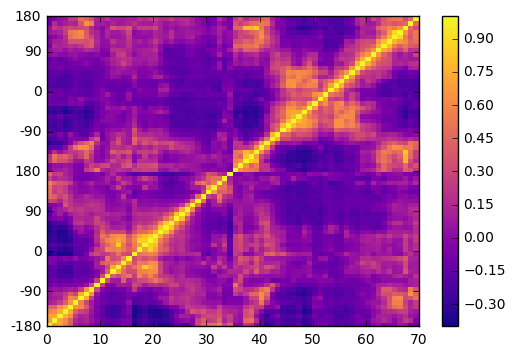

In [43]:
a = heightMaps['02_Sol1_Arg']['Sol_Arg1_P2_MR']
b = heightMaps['02_Sol1_Arg']['Sol_Arg1_P2_FL']
combine = a + b

motionAcrossVideosForAllVideos = np.corrcoef(a,b)

# plotting the correlation matrix
from pylab import pcolor, show, yticks, xticks, colorbar
pcolor(motionAcrossVideosForAllVideos, cmap = 'plasma')
yticks([0,8,17,26,35,44,53,62,70],[-180,-90,0,90,180,-90,0,90,180])

colorbar()
show()

In [159]:
num =0
for x in list(heightMaps.keys()): #How many videos are there in the folders?
    for y in list(heightMaps[x].keys()):
        num += 1
print(num)

48


In [176]:
myList = [[0]*3 for x in range(3)]
myList[0][0]=1
myList

[[1, 0, 0], [0, 0, 0], [0, 0, 0]]

In [17]:
list(heightMaps[list(heightMaps.keys())[0]].keys())

['Sol_Lau2_P2_FR',
 'Sol_Lau4_P3_ML',
 'Sol_Lau1_P1_FR',
 'Sol_Lau5_P3_FR',
 'Sol_Lau4_P3_FR',
 'Sol_Lau2_P2_ML',
 'Sol_Lau1_P1_ML',
 'Sol_Lau5_P3_ML']

In [7]:
for category, v in heightMaps.items():
    if isinstance(v, dict):
        for stimulus, heightMap in v.items():
            #2. Again for each HeightMap - input2 to crosscorrelation
            for category1, v1 in heightMaps.items():
                if isinstance(v1, dict):
                    for stimulus1, heightMap1 in v.items():
                        crossCorrelation = np.corrcoef(heightMap,heightMap1)
                        #standardDevCrossCorr[1].append(np.std(crossCorrelation))
                        #std = np.std(crossCorrelation[35:,:35].flatten())
                else:
                    raise ValueError('Toplevel dictionary should only contain dictionaries')
    else:
        raise ValueError('Toplevel dictionary should only contain dictionaries')

ValueError: all the input array dimensions except for the concatenation axis must match exactly